# **10. 도로 영역을 찾자! - 세그멘테이션 모델 만들기**

# **10-1. 들어가며**

 Semantic Segmentation(시맨틱 세그멘테이션) 을 이용해서 자율주행차량이 주행해야 할 도로 영역을 찾는 상황을 가정하고 모델을 만들어보기  
 U-Net을 사용해서 이미지가 입력되면 도로의 영역을 Segmentation 하는 모델을 만들어보기

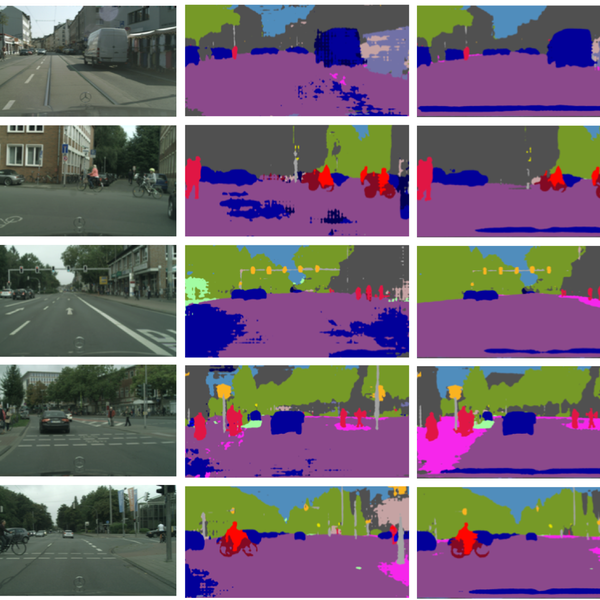

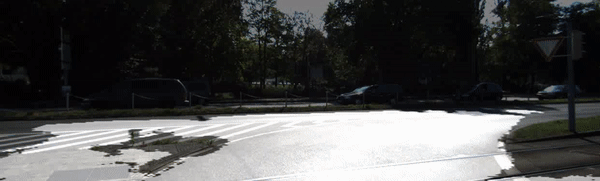

입력 이미지 위에 도로 영역으로 인식한 영역을 흰색으로 오버레이 한 이미지

실습목표
- 시맨틱 세그멘테이션 데이터셋을 전처리할 수 있습니다.
- 시맨틱 세그멘테이션 모델을 만들고 학습할 수 있습니다.
- 시맨틱 세그멘테이션 모델의 결과를 시각화할 수 있습니다.

학습내용
- 시맨틱 세그멘테이션 데이터셋
- 시맨틱 세그멘테이션 모델
- 시맨틱 세그멘테이션 모델 시각화


# **10-2. 시맨틱 세그멘테이션 데이터셋**

### **이미지, 데이터 가져오기**

 KITTI 데이터셋의 세그멘테이션 데이터 를 다운로드
 (http://www.cvlibs.net/datasets/kitti/eval_semantics.php)

In [ ]:
# ! mkdir -p ~/aiffel/semantic_segmentation/data

In [ ]:
# ! ln -s  ~/data/* ~/aiffel/semantic_segmentation/data/

In [ ]:
!wget https://gd10-data.s3.ap-northeast-2.amazonaws.com/data.zip # 데이터 다운로드

--2022-04-12 13:16:23--  https://gd10-data.s3.ap-northeast-2.amazonaws.com/data.zip
Resolving gd10-data.s3.ap-northeast-2.amazonaws.com (gd10-data.s3.ap-northeast-2.amazonaws.com)... 52.219.148.94
Connecting to gd10-data.s3.ap-northeast-2.amazonaws.com (gd10-data.s3.ap-northeast-2.amazonaws.com)|52.219.148.94|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 680475564 (649M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>] 648.95M  44.6MB/s    in 15s     

2022-04-12 13:16:39 (42.3 MB/s) - ‘data.zip’ saved [680475564/680475564]



In [ ]:
!unzip data.zip # 데이터 압축풀기

Archive:  data.zip
   creating: data/
   creating: data/testing/
   creating: data/testing/image_2/
  inflating: data/testing/image_2/000140_10.png  
  inflating: data/testing/image_2/000122_10.png  
  inflating: data/testing/image_2/000133_10.png  
  inflating: data/testing/image_2/000062_10.png  
  inflating: data/testing/image_2/000014_10.png  
  inflating: data/testing/image_2/000056_10.png  
  inflating: data/testing/image_2/000199_10.png  
  inflating: data/testing/image_2/000175_10.png  
  inflating: data/testing/image_2/000078_10.png  
  inflating: data/testing/image_2/000020_10.png  
  inflating: data/testing/image_2/000186_10.png  
  inflating: data/testing/image_2/000054_10.png  
  inflating: data/testing/image_2/000051_10.png  
  inflating: data/testing/image_2/000040_10.png  
  inflating: data/testing/image_2/000193_10.png  
  inflating: data/testing/image_2/000103_10.png  
  inflating: data/testing/image_2/000029_10.png  
  inflating: data/testing/image_2/000028_10.png  


In [ ]:
 dir_path = '/content/drive/MyDrive/GD/kitti_segmentation' # 코랩경로

In [ ]:
!mv data/ /content/drive/MyDrive/GD/kitti_segmentation/ # MyDrive로 파일 이동

In [ ]:
!rm data.zip

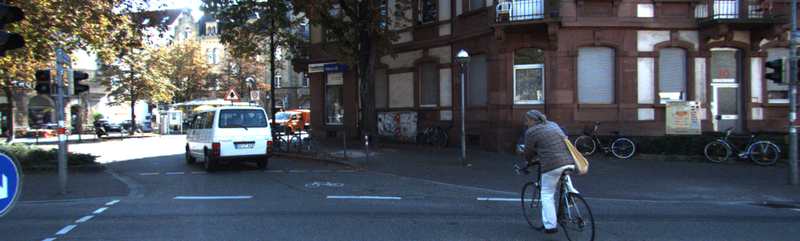

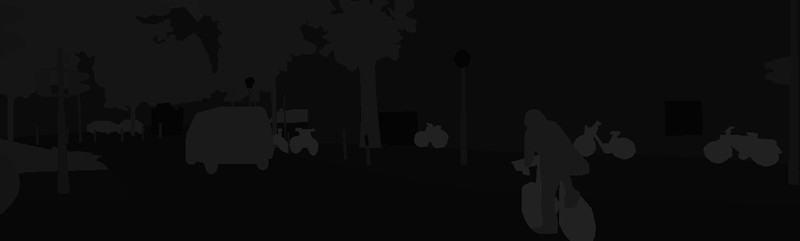

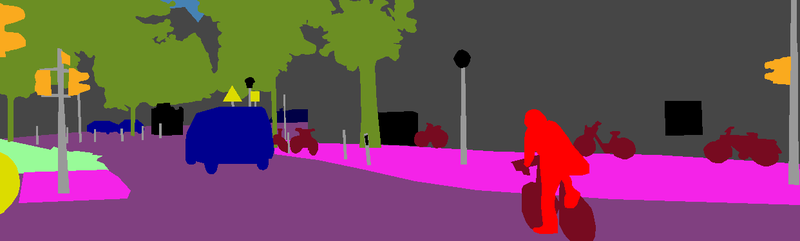

### **데이터 로더(data loader) 만들기**

모델을 학습시킬 수 있는 데이터 로더(data loader)를 만들기  
로더는 입력값 (224, 224), 출력값 (224, 244) 크기를 갖는 모델을 학습시킬 수 있도록 데이터셋을 파싱   
이때 데이터 로더에 augmentation 을 적용 (파이썬에서 많이 사용되는 albumentations을 사용)  
학습셋의 일정량을 검증 데이터셋(validation dataset) 으로 활용

구현을 할 때의 참고자료
- Keras Sequence에 기반한 Dataloader (https://hwiyong.tistory.com/241)
- Albumentation을 적용한 Keras sequence  
 (https://medium.com/the-artificial-impostor/custom-image-augmentation-with-keras-70595b01aeac)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip list | grep albumentations

albumentations                0.1.12


In [ ]:
#필요한 라이브러리를 로드합니다. 
import os,  datetime
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

아래는 Albumentation에서 다양한 augmentation 기법을 확률적으로 적용할 수 있게 해주는 Compose()의 활용예, . imgaug의 Sometimes()와 유사한 기능

In [ ]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

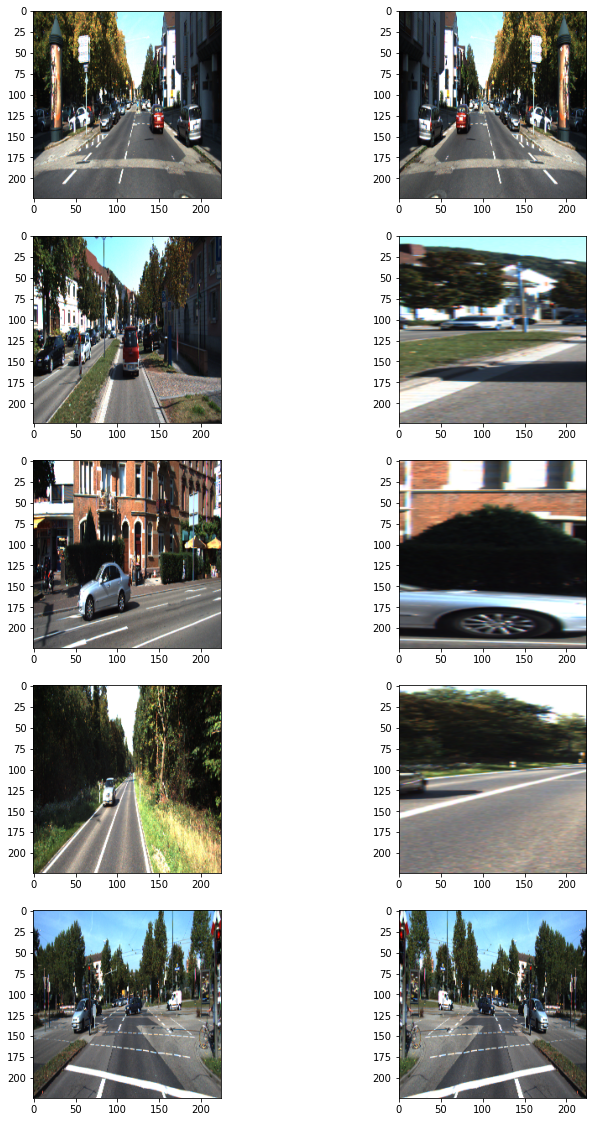

In [ ]:
import os

dir_path = '/content/drive/MyDrive/GD/kitti_segmentation/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

tf.keras.utils.Sequence를 상속받은 generator 형태로 데이터를 구성

In [ ]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=16,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path입니다.
    batch_size: batch_size입니다.
    img_size: preprocess에 사용할 입력이미지의 크기입니다.
    output_size: ground_truth를 만들어주기 위한 크기입니다.
    is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듭니다.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label입니다.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [ ]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

# **10-3. 시맨틱 세그멘테이션 모델**

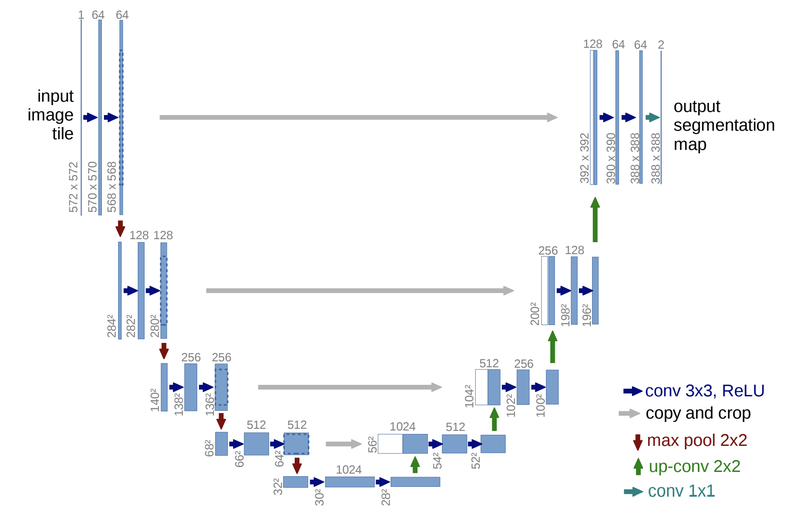

### **모델 구조 만들기**

시맨틱 세그멘테이션 모델 중 구조상 비교적 구현이 단순한 U-Net을 구현 (U-Net에 패딩을 적용)   
이때 입력 이미지의 크기는 위에서 만든 데이터셋에 맞춰서 만든다   
사용에 필요한 레이어와 연산  
Conv2D, Conv2DTranspose, MaxPooling2D, concatenate

In [ ]:
def build_model(input_shape=(224, 224, 3)):
  inputs = Input(input_shape)
	
  #Contracting Path
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
  
  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)
  
  #Expanding Path
  drop5 = Dropout(0.5)(conv5)
  up6 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop5)
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
  conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
  up7 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv6)
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
  conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
  up8 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv7)
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
  conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
  up9 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv8)
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
  conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
  conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
  conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

  model = Model(inputs = inputs, outputs = conv10)
  return model

### **모델 학습하기**

In [ ]:
model_path = '/content/drive/MyDrive/GD/GD_10/seg_model_unet.h5'

model = build_model()
model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
11/11 [==============================] - 8s 626ms/step - loss: 0.6806 - val_loss: 0.6727
Epoch 2/100
11/11 [==============================] - 7s 606ms/step - loss: 0.6345 - val_loss: 0.3961
Epoch 3/100
11/11 [==============================] - 7s 605ms/step - loss: 0.0718 - val_loss: 0.0385
Epoch 4/100
11/11 [==============================] - 7s 600ms/step - loss: 0.0288 - val_loss: 0.0385
Epoch 5/100
11/11 [==============================] - 7s 594ms/step - loss: 0.0316 - val_loss: 0.0393
Epoch 6/100
11/11 [==============================] - 7s 600ms/step - loss: 0.0327 - val_loss: 0.0318
Epoch 7/100
11/11 [==============================] - 7s 613ms/step - loss: 0.0306 - val_loss: 0.0290
Epoch 8/100
11/11 [==============================] - 7s 611ms/step - loss: 0.0339 - val_loss: 0.0336
Epoch 9/100
11/11 [==============================] - 7s 605ms/step - loss: 0.0261 - val_loss: 0.0309
Epoch 10/100
11/11 [==============================] - 7s 606ms/step - loss: 0.0213 - val_lo

# **10-4. 시맨틱 세그멘테이션 모델 시각화**

학습한 모델의 결과를 눈으로 확인해 볼 차례  
이전 스텝에서 저장한 모델이나 제공된 모델을 다음 코드를 통해 불러오면  

In [ ]:
model_path = '/content/drive/MyDrive/GD/GD_10/seg_model_unet.h5'

model = tf.keras.models.load_model(model_path)

테스트 셋은 이미지를 제공하지만 정답 데이터를 제공하지 않으니 눈으로 확인할 수 있도록   
모델이 추론(inference)한 결과를 우리의 눈으로 볼 수 있는 세그멘테이션 이미지로 만든다.  
이때 입력 이미지와 라벨을 한 번에 볼 수 있도록,   
모델의 출력값을 입력 이미지 위에 겹쳐서 보이기, 즉 오버레이(overray)한다.   
PIL 패키지를 사용하신다면 Image.blend를 활용

get_output이라는 이름의 함수로 만들면

In [ ]:
def get_output(model, preproc, image_path, output_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()
    return output 

위에서 작성한 함수를 이용해 시각화

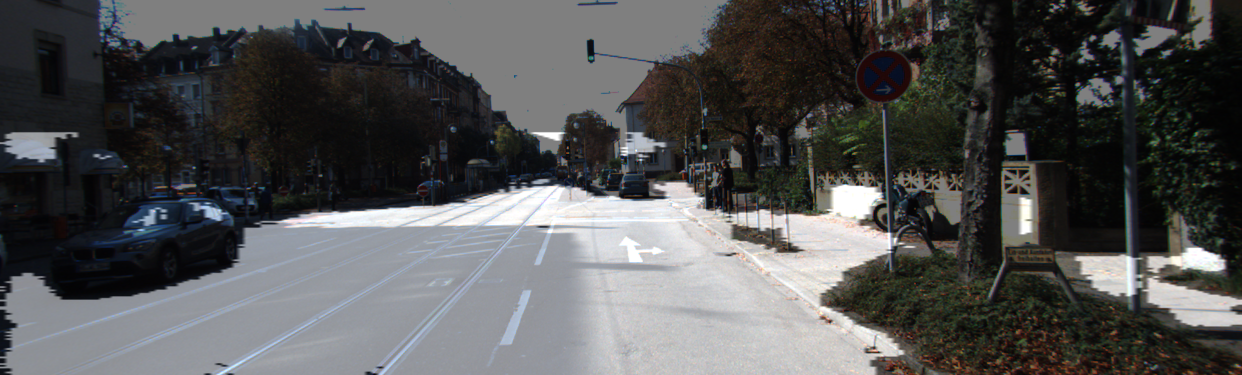

In [ ]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

세그멘테이션이 성능을 정량적으로 측정하기 위한 방법으로 IoU(Intersection over Union)를 계산   

IoU를 계산하려면 모델이 도로 영역이라고 판단한 부분이 1로, 나머지 부분이 0으로 표시된 행렬,  
그리고 라벨 데이터에서 도로 영역이 1, 나머지 부분이 0으로 표시된 행렬이 필요  
각각을 prediction, target이라고 불렀을 때 이를 계산하는 함수를 구현한다.  
위에 구현했던 get_output을 좀 더 확장해서 output, prediction, target을 함께 리턴하도록 구현  

In [ ]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [ ]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [ ]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.803229


0.8032289950576607

# **10-5. 프로젝트 : 개선된 U-Net 모델 만들기**

2018년에 U-Net++라는 논문  
U-Net의 네트워크 구조에 DenseNet의 아이디어를 가미하여 성능을 개선한 모델  
논문은 2020년에 한 번 더 업그레이드  
- U-Net++: v1 (https://arxiv.org/abs/1807.10165)
- U-Net++: v2 (https://arxiv.org/abs/1912.05074)

모델의 구조
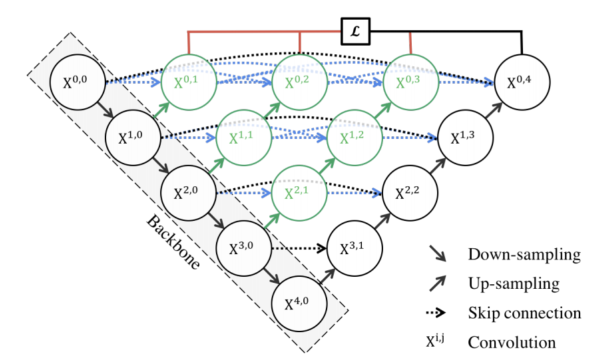

오늘의 과제  
1.U-Net++ 모델을 스스로의 힘으로 직접 구현  
2.U-Net을 활용했던 도로 세그멘테이션 태스크에 적용하여 U-Net을 썼을 때보다 성능이 향상되었음을 확인해 보는 것  

정성적으로는 두 모델의 세그멘테이션 결과를 시각화해서 비교  
정량적으로는 동일 이미지에 대한 IoU 값을 비교  

참고할 수 있는 코드 (keras로 구현)  
U-Net++:Github (https://github.com/MrGiovanni/UNetPlusPlus)


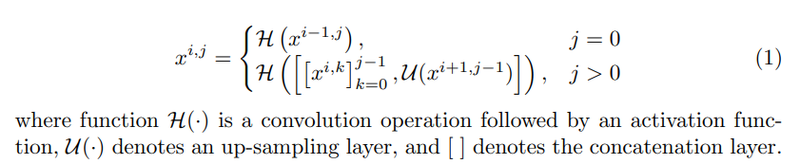

코드 중에서 가장 중요한 부분 :build_xnet (https://github.com/MrGiovanni/UNetPlusPlus/blob/e145ba63862982bf1099cf2ec11d5466b434ae0b/keras/segmentation_models/xnet/builder.py#L12)

코드 중 up_block으로는 두 가지 방식을 사용  
Loss를 조금 다르게 구현해야 한다.   
binary cross-entropy와 dice coefficient를 사용  

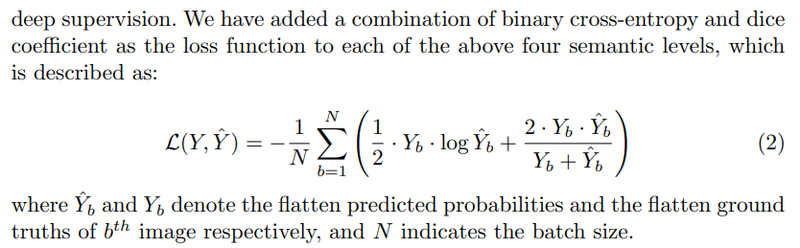

## **Step 0. 주요 라이브러리 버전 체크**

In [ ]:
import tensorflow as tf
import numpy as np
import PIL
import skimage
import albumentations

print(tf.__version__)
print(np.__version__)
print(PIL.__version__)
print(skimage.__version__)
print(albumentations.__version__)

2.8.0
1.21.5
7.1.2
0.18.3
0.1.12


## **Step 1. KITTI 데이터셋 수집과 구축**

다운로드한 KITTI 데이터에 data augmentation을 적용한 형태로 데이터셋을 구축  
주의할 점: 배치 사이즈를 적절히 줄여서 설정  

### **앞에서 진행한 관계로 생략함**

## **Step 2. U-Net++ 모델의 구현**

In [ ]:
def build_unetpp(input_shape=(224, 224, 3), deep_supervision=False):
    inputs = Input(input_shape)
  
    # 순차적으로 진행하며 해당 시점에서 만들수 있는 블럭을 모두 만든다.

    # First
    conv_0_0 = Conv2D(32, 3, activation='relu', kernel_initializer='he_normal', padding='same', name='conv_0_0_stage_1')(inputs)
    conv_0_0 = Conv2D(32, 3, activation='relu', kernel_initializer='he_normal', padding='same', name='conv_0_0_stage_2')(conv_0_0)
    

    # Second
    mp_1 = MaxPool2D(pool_size=(2,2), name='max_pooling_1_0')(conv_0_0)
    conv_1_0 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same', name='conv_1_0_stage_1')(mp_1)
    conv_1_0 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same', name='conv_1_0_stage_2')(conv_1_0)

    up_0_1 = Conv2DTranspose(32, 2, strides=(2,2), activation='relu', kernel_initializer='he_normal', name='up_conv_0_1')(conv_1_0)
    conv_0_1 = concatenate([up_0_1, conv_0_0], axis=3, name='concatenate_0_1')
    conv_0_1 = Conv2D(32, 3, activation='relu', kernel_initializer='he_normal', padding='same', name='conv_0_1_stage_1')(conv_0_1)
    conv_0_1 = Conv2D(32, 3, activation='relu', kernel_initializer='he_normal', padding='same', name='conv_0_1_stage_2')(conv_0_1)


    # Third
    mp_2 = MaxPool2D(pool_size=(2,2), name='max_pooling_2_0')(conv_1_0)
    conv_2_0 = Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same', name='conv_2_0_stage_1')(mp_2)
    conv_2_0 = Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same', name='conv_2_0_stage_2')(conv_2_0)

    up_1_1 = Conv2DTranspose(64, 2, strides=(2,2), activation='relu', kernel_initializer='he_normal', name='up_conv_1_1')(conv_2_0)
    conv_1_1 = concatenate([up_1_1, conv_1_0], axis=3, name='concatenate_1_1')
    conv_1_1 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same', name='conv_1_1_stage_1')(conv_1_1)
    conv_1_1 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same', name='conv_1_1_stage_2')(conv_1_1)

    up_0_2 = Conv2DTranspose(32, 2, strides=(2,2), activation='relu', kernel_initializer='he_normal', name='up_conv_0_2')(conv_1_1)
    conv_0_2 = concatenate([up_0_2, conv_0_0, conv_0_1], axis=3, name='concatenate_0_2')
    conv_0_2 = Conv2D(32, 3, activation='relu', kernel_initializer='he_normal', padding='same', name='conv_0_2_stage_1')(conv_0_2)
    conv_0_2 = Conv2D(32, 3, activation='relu', kernel_initializer='he_normal', padding='same', name='conv_0_2_stage_2')(conv_0_2)


    # Fourth
    mp_3 = MaxPool2D(pool_size=(2,2), name='max_pooling_3_0')(conv_2_0)
    conv_3_0 = Conv2D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same', name='conv_3_0_stage_1')(mp_3)
    conv_3_0 = Conv2D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same', name='conv_3_0_stage_2')(conv_3_0)
    
    up_2_1 = Conv2DTranspose(128, 2, strides=(2,2), activation='relu', kernel_initializer='he_normal', name='up_conv_2_1')(conv_3_0)
    conv_2_1 = concatenate([up_2_1, conv_2_0], axis=3, name='concatenate_2_1')
    conv_2_1 = Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same', name='conv_2_1_stage_1')(conv_2_1)
    conv_2_1 = Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same', name='conv_2_1_stage_2')(conv_2_1)

    up_1_2 = Conv2DTranspose(64, 2, strides=(2,2), activation='relu', kernel_initializer='he_normal', name='up_conv_1_2')(conv_2_1)
    conv_1_2 = concatenate([up_1_2, conv_1_0, conv_1_1], axis=3, name='concatenate_1_2')
    conv_1_2 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same', name='conv_1_2_stage_1')(conv_1_2)
    conv_1_2 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same', name='conv_1_2_stage_2')(conv_1_2)

    up_0_3 = Conv2DTranspose(32, 2, strides=(2,2), activation='relu', kernel_initializer='he_normal', name='up_conv_0_3')(conv_1_2)
    conv_0_3 = concatenate([up_0_3, conv_0_0, conv_0_1, conv_0_2], axis=3, name='concatenate_0_3')
    conv_0_3 = Conv2D(32, 3, activation='relu', kernel_initializer='he_normal', padding='same', name='conv_0_3_stage_1')(conv_0_3)
    conv_0_3 = Conv2D(32, 3, activation='relu', kernel_initializer='he_normal', padding='same', name='conv_0_3_stage_2')(conv_0_3)


    # Fifth
    mp_4 = MaxPool2D(pool_size=(2,2), name='max_pooling_4_0')(conv_3_0)
    conv_4_0 = Conv2D(512, 3, activation='relu', kernel_initializer='he_normal', padding='same', name='conv_4_0_stage_1')(mp_4)
    conv_4_0 = Conv2D(512, 3, activation='relu', kernel_initializer='he_normal', padding='same', name='conv_4_0_stage_2')(conv_4_0)
    
    up_3_1 = Conv2DTranspose(256, 2, strides=(2,2), activation='relu', kernel_initializer='he_normal', name='up_conv_3_1')(conv_4_0)
    conv_3_1 = concatenate([up_3_1, conv_3_0], axis=3, name='concatenate_3_1')
    conv_3_1 = Conv2D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same', name='conv_3_1_stage_1')(conv_3_1)
    conv_3_1 = Conv2D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same', name='conv_3_1_stage_2')(conv_3_1)

    up_2_2 = Conv2DTranspose(128, 2, strides=(2,2), activation='relu', kernel_initializer='he_normal', name='up_conv_2_2')(conv_3_1)
    conv_2_2 = concatenate([up_2_2, conv_2_0, conv_2_1], axis=3, name='concatenate_2_2')
    conv_2_2 = Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same', name='conv_2_2_stage_1')(conv_2_2)
    conv_2_2 = Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same', name='conv_2_2_stage_2')(conv_2_2)

    up_1_3 = Conv2DTranspose(64, 2, strides=(2,2), activation='relu', kernel_initializer='he_normal', name='up_conv_1_3')(conv_2_2)
    conv_1_3 = concatenate([up_1_3, conv_1_0, conv_1_1, conv_1_2], axis=3, name='concatenate_1_3')
    conv_1_3 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same', name='conv_1_3_stage_1')(conv_1_3)
    conv_1_3 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same', name='conv_1_3_stage_2')(conv_1_3)

    up_0_4 = Conv2DTranspose(32, 2, strides=(2,2), activation='relu', kernel_initializer='he_normal', name='up_conv_0_4')(conv_1_3)
    conv_0_4 = concatenate([up_0_4, conv_0_0, conv_0_1, conv_0_2, conv_0_3], axis=3, name='concatenate_0_4')
    conv_0_4 = Conv2D(32, 3, activation='relu', kernel_initializer='he_normal', padding='same', name='conv_0_4_stage_1')(conv_0_4)
    conv_0_4 = Conv2D(32, 3, activation='relu', kernel_initializer='he_normal', padding='same', name='conv_0_4_stage_2')(conv_0_4)
    

    # output
    output_1 = Conv2D(1, 1, activation='sigmoid', kernel_initializer='he_normal', name='output_0_1')(conv_0_1)
    output_2 = Conv2D(1, 1, activation='sigmoid', kernel_initializer='he_normal', name='output_0_2')(conv_0_2)
    output_3 = Conv2D(1, 1, activation='sigmoid', kernel_initializer='he_normal', name='output_0_3')(conv_0_3)
    output_4 = Conv2D(1, 1, activation='sigmoid', kernel_initializer='he_normal', name='output_0_4')(conv_0_4)
   
    if deep_supervision:
      outputs = (output_1 + output_2 + output_3 + output_4) / 4
    else:
      outputs = output_4
    
    model = Model(inputs=inputs, outputs=outputs)
    # TODO: input_shape에 따라 U-Net을 만들어주세요
    # 이때 model은 fully convolutional해야 합니다.
    return model

In [ ]:
model_unetpp_dp = build_unetpp(deep_supervision=True)
model_unetpp_dp.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_0_0_stage_1 (Conv2D)      (None, 224, 224, 32  896         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 conv_0_0_stage_2 (Conv2D)      (None, 224, 224, 32  9248        ['conv_0_0_stage_1[0][0]']       
                                )                                                           

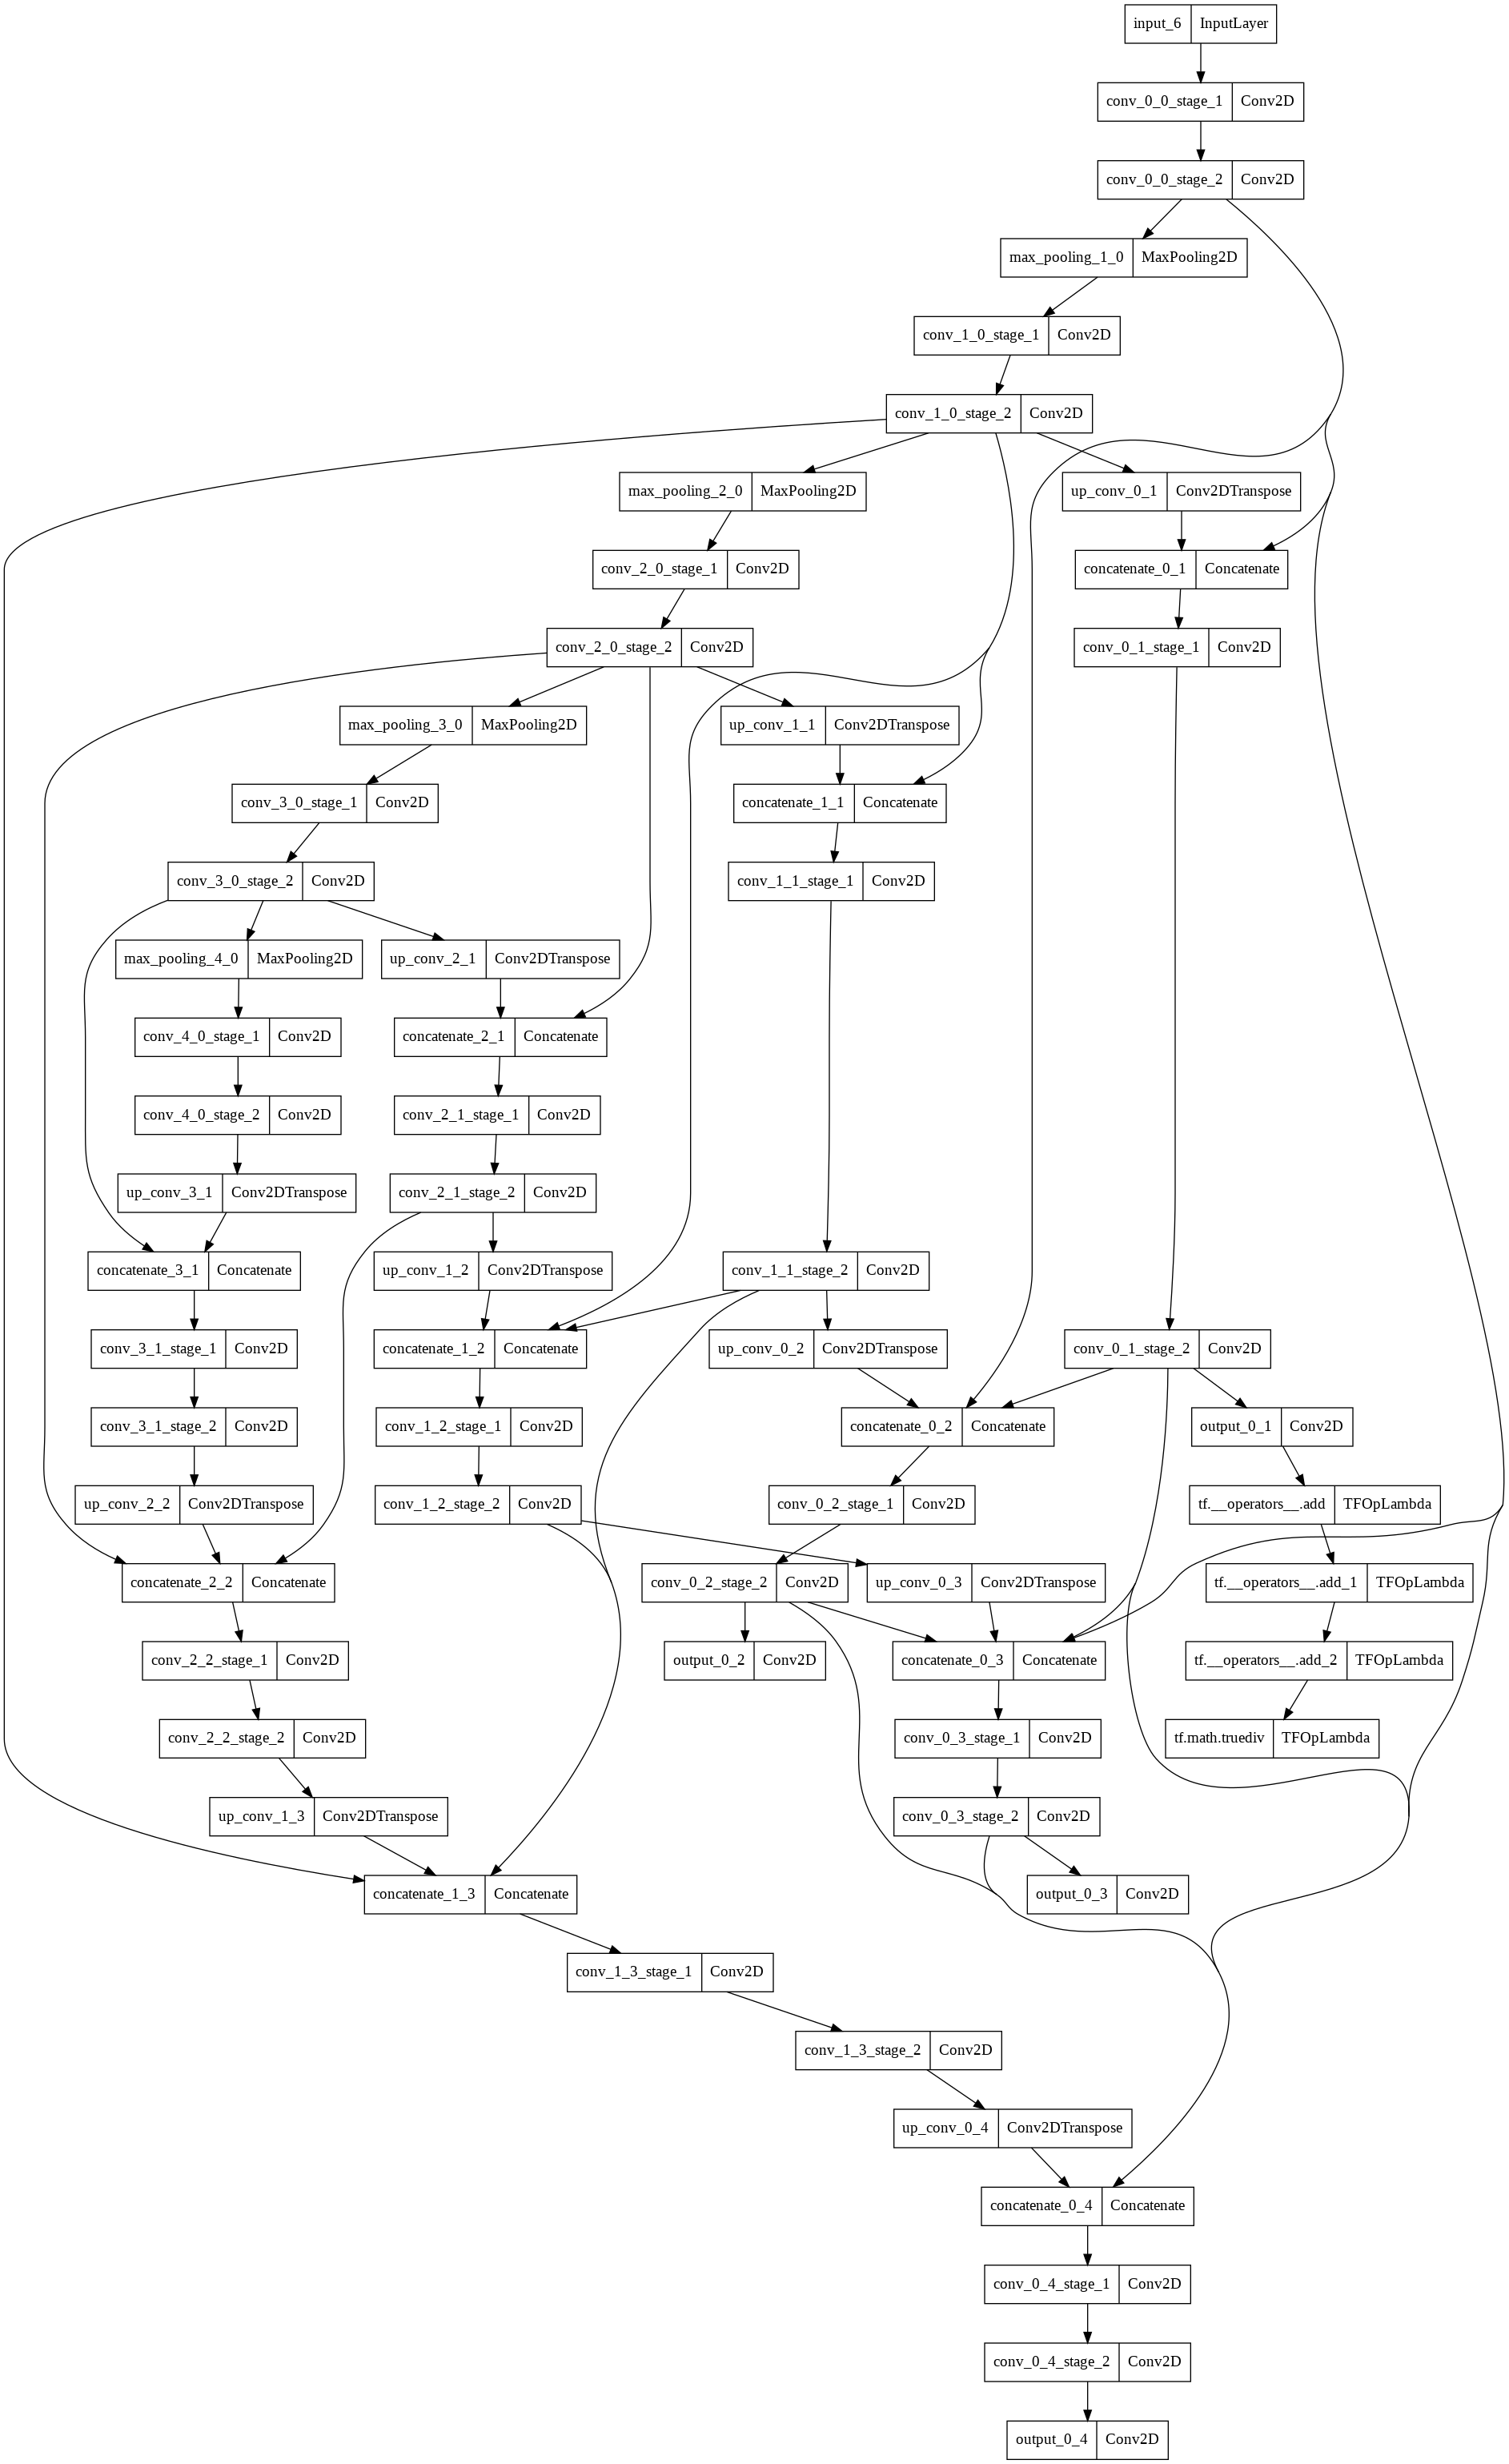

In [ ]:
tf.keras.utils.plot_model(model_unetpp_dp)

In [ ]:
from keras import backend as K

# 노드에서 소개한 dice coefficient 함수
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# dice coefficient를 이용한 loss 함수
def dice_coef_loss(y_true, y_pred):
    return 1. - dice_coef(y_true, y_pred)

# binary crosentropy와 dice coefficient loss를 복합적으로 사용하여 새로운 loss 값을 반환하는 함수
def bce_dice_loss(y_true, y_pred):
    #return 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)
    return 1 + 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred) # 값이 음수가 되는 경우도 있어 1을 더해줌

# 위의 loss가 왜 저렇게 구성되었는지 이해가 안되어 bce와 de의 가중치를 0.5씩 주어 합한 loss 새로 정의
def new_bce_dice_loss(y_true, y_pred):
    return 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * dice_coef_loss(y_true, y_pred)

# IoU를 계산하는 함수. Metric으로 활용 예정
def iou_seg(y_true, y_pred, dtype=tf.float32):
    # tf tensor casting
    y_pred = tf.convert_to_tensor(y_pred)
    y_pred = tf.cast(y_pred, dtype)
    y_true = tf.cast(y_true, y_pred.dtype)

    y_pred = tf.squeeze(y_pred)
    y_true = tf.squeeze(y_true)
    
    y_true_pos = tf.reshape(y_true, [-1])
    y_pred_pos = tf.reshape(y_pred, [-1])

    area_intersect = tf.reduce_sum(tf.multiply(y_true_pos, y_pred_pos))
    
    area_true = tf.reduce_sum(y_true_pos)
    area_pred = tf.reduce_sum(y_pred_pos)
    area_union = area_true + area_pred - area_intersect
    
    # return 1-tf.math.divide_no_nan(area_intersect, area_union)
    return tf.math.divide_no_nan(area_intersect, area_union) # loss 형태로 반환하기에, IoU값을 그대로 반환하기 위해 수정

In [ ]:
model_path = '/content/drive/MyDrive/GD/GD_10/checkpoint/unetpp_dp'
MD = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_path,
    save_weights_only=False,
    monitor='val_iou_seg',
    mode='max',
    save_best_only=True,
)

ES = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1
)

In [ ]:
model_path = '/content/drive/MyDrive/GD/GD_10/unetpp_dp_min.h5'

model_unetpp_dp = build_unetpp(deep_supervision=True)

model_unetpp_dp.compile(optimizer = Adam(1e-4), loss = bce_dice_loss, metrics=iou_seg)

history_dp = model_unetpp_dp.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
     callbacks=[MD, ES]
 )

model_unetpp_dp.save(model_path)

Epoch 1/100
11/11 [==============================] - 11s 725ms/step - loss: 1.3152 - iou_seg: 0.0174 - val_loss: 1.3076 - val_iou_seg: 0.0207
Epoch 2/100
11/11 [==============================] - 7s 639ms/step - loss: 1.3071 - iou_seg: 0.0217 - val_loss: 1.3014 - val_iou_seg: 0.0230
Epoch 3/100
11/11 [==============================] - 7s 644ms/step - loss: 1.3049 - iou_seg: 0.0157 - val_loss: 1.2742 - val_iou_seg: 0.0231
Epoch 4/100
11/11 [==============================] - 7s 646ms/step - loss: 1.2210 - iou_seg: 0.0194 - val_loss: 1.1582 - val_iou_seg: 0.0234
Epoch 5/100
11/11 [==============================] - 7s 642ms/step - loss: 1.1201 - iou_seg: 0.0238 - val_loss: 1.0655 - val_iou_seg: 0.0404
Epoch 6/100
11/11 [==============================] - 13s 1s/step - loss: 1.0611 - iou_seg: 0.0367 - val_loss: 1.0020 - val_iou_seg: 0.0581
Epoch 7/100
11/11 [==============================] - 14s 1s/step - loss: 0.9796 - iou_seg: 0.0592 - val_loss: 0.9142 - val_iou_seg: 0.0845
Epoch 8/100
11/1

In [ ]:
model_path = '/content/drive/MyDrive/GD/GD_10/unetpp_dp_min.h5'

model_unetpp_dp = tf.keras.models.load_model(model_path, custom_objects={'bce_dice_loss':bce_dice_loss, 'iou_seg': iou_seg})

In [ ]:
model_path = '/content/drive/MyDrive/GD/GD_10/checkpoint/unetpp_dp_bc'
MD = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_path,
    save_weights_only=False,
    monitor='val_iou_seg',
    mode='max',
    save_best_only=True,
)

ES = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1
)

In [ ]:
model_unetpp_dp_bc = build_unetpp(deep_supervision=True)

model_unetpp_dp_bc.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy', metrics=iou_seg)
history_dp_bc = model_unetpp_dp_bc.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
     callbacks=[MD, ES]
 )

model_path = '/content/drive/MyDrive/GD/GD_10/unetpp_dp_bc_min.h5'
model_unetpp_dp_bc.save(model_path)

Epoch 1/100
11/11 [==============================] - 16s 1s/step - loss: 0.6891 - iou_seg: 0.0101 - val_loss: 0.6821 - val_iou_seg: 0.0135
Epoch 2/100
11/11 [==============================] - 7s 623ms/step - loss: 0.6774 - iou_seg: 0.0099 - val_loss: 0.6619 - val_iou_seg: 0.0115
Epoch 3/100
11/11 [==============================] - 7s 627ms/step - loss: 0.6194 - iou_seg: 0.0071 - val_loss: 0.4782 - val_iou_seg: 0.0080
Epoch 4/100
11/11 [==============================] - 7s 630ms/step - loss: 0.3374 - iou_seg: 0.0068 - val_loss: 0.2812 - val_iou_seg: 0.0116
Epoch 5/100
11/11 [==============================] - 13s 1s/step - loss: 0.2552 - iou_seg: 0.0107 - val_loss: 0.2197 - val_iou_seg: 0.0151
Epoch 6/100
11/11 [==============================] - 14s 1s/step - loss: 0.1629 - iou_seg: 0.0174 - val_loss: 0.1189 - val_iou_seg: 0.0308
Epoch 7/100
11/11 [==============================] - 14s 1s/step - loss: 0.1012 - iou_seg: 0.0430 - val_loss: 0.0817 - val_iou_seg: 0.0564
Epoch 8/100
11/11 [==

In [ ]:
model_path = '/content/drive/MyDrive/GD/GD_10/unetpp_dp_bc_min.h5'

model_unetpp_dp_bc = tf.keras.models.load_model(model_path, custom_objects={'iou_seg': iou_seg})

In [ ]:
model_path = '/content/drive/MyDrive/GD/GD_10/checkpoint/unetpp_dp_dc'
MD = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_path,
    save_weights_only=False,
    monitor='val_iou_seg',
    mode='max',
    save_best_only=True,
)

ES = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    verbose=1
)

In [ ]:
model_unetpp_dp_dc = build_unetpp(deep_supervision=True)

model_unetpp_dp_dc.compile(optimizer = Adam(1e-4), loss = dice_coef_loss, metrics=iou_seg)

history_dp_dc = model_unetpp_dp_dc.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
     callbacks=[MD, ES]
 )

model_path = '/content/drive/MyDrive/GD/GD_10/checkpoint/unetpp_dp_dc'
model_unetpp_dp_dc.save(model_path)

Epoch 1/100
11/11 [==============================] - 17s 1s/step - loss: 0.9708 - iou_seg: 0.0149 - val_loss: 0.9578 - val_iou_seg: 0.0215
Epoch 2/100
11/11 [==============================] - 14s 1s/step - loss: 0.9534 - iou_seg: 0.0239 - val_loss: 0.9463 - val_iou_seg: 0.0276
Epoch 3/100
11/11 [==============================] - 13s 1s/step - loss: 0.9558 - iou_seg: 0.0229 - val_loss: 0.9394 - val_iou_seg: 0.0313
Epoch 4/100
11/11 [==============================] - 14s 1s/step - loss: 0.9422 - iou_seg: 0.0299 - val_loss: 0.9365 - val_iou_seg: 0.0328
Epoch 5/100
11/11 [==============================] - 14s 1s/step - loss: 0.9613 - iou_seg: 0.0200 - val_loss: 0.9348 - val_iou_seg: 0.0337
Epoch 6/100
11/11 [==============================] - 14s 1s/step - loss: 0.9464 - iou_seg: 0.0279 - val_loss: 0.9337 - val_iou_seg: 0.0343
Epoch 7/100
11/11 [==============================] - 13s 1s/step - loss: 0.9389 - iou_seg: 0.0317 - val_loss: 0.9328 - val_iou_seg: 0.0348
Epoch 8/100
11/11 [========

In [ ]:
model_path = '/content/drive/MyDrive/GD/GD_10/unetpp_dp_dc_min.h5'


model_unetpp_dp_dc = tf.keras.models.load_model(model_path, custom_objects={'iou_seg': iou_seg})

OSError: ignored

Deep Supervision을 포함하지 않은 모델도 학습

In [ ]:
model_path = '/content/drive/MyDrive/GD/GD_10/checkpoint/unetpp'
MD = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_path,
    save_weights_only=False,
    monitor='val_iou_seg',
    mode='max',
    save_best_only=True,
)

ES = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1
)

In [ ]:
model_unetpp = build_unetpp()

model_unetpp.compile(optimizer = Adam(1e-4), loss = bce_dice_loss, metrics=iou_seg)

history_org = model_unetpp.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
     callbacks=[MD, ES]
 )

model_path = '/content/drive/MyDrive/GD/GD_10/unetpp_min.h5'
model_unetpp.save(model_path)

Epoch 1/100
11/11 [==============================] - 16s 1s/step - loss: 1.3071 - iou_seg: 0.0239 - val_loss: 1.3075 - val_iou_seg: 0.0232
Epoch 2/100
11/11 [==============================] - 7s 609ms/step - loss: 1.3181 - iou_seg: 0.0160 - val_loss: 1.3024 - val_iou_seg: 0.0199
Epoch 3/100
11/11 [==============================] - 7s 613ms/step - loss: 1.3019 - iou_seg: 0.0174 - val_loss: 1.2811 - val_iou_seg: 0.0218
Epoch 4/100
11/11 [==============================] - 13s 1s/step - loss: 1.2592 - iou_seg: 0.0178 - val_loss: 1.1736 - val_iou_seg: 0.0252
Epoch 5/100
11/11 [==============================] - 7s 619ms/step - loss: 1.1022 - iou_seg: 0.0133 - val_loss: 1.1348 - val_iou_seg: 0.0011
Epoch 6/100
11/11 [==============================] - 7s 622ms/step - loss: 1.1298 - iou_seg: 3.5921e-04 - val_loss: 1.1364 - val_iou_seg: 8.6157e-04
Epoch 7/100
11/11 [==============================] - 13s 1s/step - loss: 1.0858 - iou_seg: 0.0044 - val_loss: 0.8438 - val_iou_seg: 0.1233
Epoch 8/100

In [ ]:
model_path = '/content/drive/MyDrive/GD/GD_10/unetpp_min.h5'

model_unetpp = tf.keras.models.load_model(model_path, custom_objects={'bce_dice_loss': bce_dice_loss,'iou_seg': iou_seg})

In [ ]:
model_path = '/content/drive/MyDrive/GD/GD_10/checkpoint/unetpp_bc'
MD = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_path,
    save_weights_only=False,
    monitor='val_iou_seg',
    mode='max',
    save_best_only=True,
)

ES = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1
)

In [ ]:
model_unetpp_bc = build_unetpp()

model_unetpp_bc.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy', metrics=iou_seg)
history_org_bc = model_unetpp_bc.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
     callbacks=[MD, ES]
 )

model_path = '/content/drive/MyDrive/GD/GD_10/unetpp_bc_min.h5'
model_unetpp_bc.save(model_path)

Epoch 1/100
11/11 [==============================] - 16s 1s/step - loss: 0.6760 - iou_seg: 0.0087 - val_loss: 0.6509 - val_iou_seg: 0.0070
Epoch 2/100
11/11 [==============================] - 13s 1s/step - loss: 0.5526 - iou_seg: 0.0054 - val_loss: 0.2751 - val_iou_seg: 0.0135
Epoch 3/100
11/11 [==============================] - 13s 1s/step - loss: 0.0822 - iou_seg: 0.1141 - val_loss: 0.0275 - val_iou_seg: 0.2848
Epoch 4/100
11/11 [==============================] - 7s 617ms/step - loss: 0.0285 - iou_seg: 0.1625 - val_loss: 0.0321 - val_iou_seg: 0.2275
Epoch 5/100
11/11 [==============================] - 7s 617ms/step - loss: 0.0289 - iou_seg: 0.2033 - val_loss: 0.0272 - val_iou_seg: 0.2751
Epoch 6/100
11/11 [==============================] - 7s 620ms/step - loss: 0.0301 - iou_seg: 0.1999 - val_loss: 0.0258 - val_iou_seg: 0.2745
Epoch 7/100
11/11 [==============================] - 13s 1s/step - loss: 0.0284 - iou_seg: 0.2116 - val_loss: 0.0257 - val_iou_seg: 0.3007
Epoch 8/100
11/11 [==

In [ ]:
model_path = '/content/drive/MyDrive/GD/GD_10/unetpp_bc_min.h5'

model_unetpp_bc = tf.keras.models.load_model(model_path, custom_objects={'iou_seg': iou_seg})

# **Step 3. U-Net 과 U-Net++ 모델이 수행한 세그멘테이션 결과 분석**

In [ ]:
def get_output(model, preproc, image_path, output_path):
  org_img = imread(image_path)
  img_data = {"image":org_img}
  
  proc_data = preproc(**img_data)
  pred = model(np.expand_dims(proc_data["image"]/255, axis=0))
  pred = (pred[0].numpy()>0.5).astype(np.uint8).squeeze()*255 # squeeze() 함수는 불필요한 차원을 축소해주는 함수인데 기존처럼 -1이 들어가 있으면 원하는 대로 축소되지 않아 괄호 안을 비워둠
  pred = Image.fromarray(pred)
  pred = pred.resize((org_img.shape[1], org_img.shape[0])).convert('RGBA')
  bg_img = Image.fromarray(org_img).convert('RGBA')

  output = Image.blend(bg_img, pred, alpha=0.6)

  # 이미지 출력을 위한 부분
  plt.figure(figsize=(15, 15))
  plt.imshow(output)

  #return output


    # TODO: image_path로 입력된 이미지를 입력받아 preprocess를 해서 model로 infernece한 결과를 시각화하고 
    # 이를 output_path에 저장하는 함수를 작성해주세요.

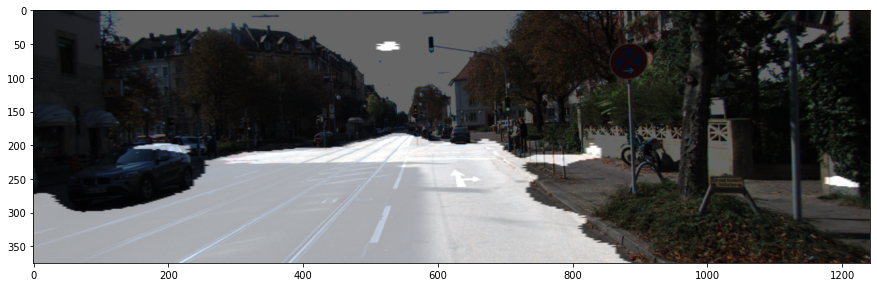

In [ ]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
get_output(
     model_unetpp_dp, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

원본 이미지와 Ground Truth 이미지를 출력하는 함수

In [ ]:
def get_origin(i): # 매개변수로 이미지 넘버값을 받는다.
  image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png'
  label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
  preproc = test_preproc

  org_img = imread(image_path)
  img_data = {"image":org_img}
  
  proc_data = preproc(**img_data)

  bg_img = Image.fromarray(org_img).convert('RGBA')

  if label_path:
    label_img = imread(label_path)
    label_data = {"image":label_img}
    proc_label = preproc(**label_data)
    proc_label = proc_label["image"]
    target = (proc_label == 7).astype(np.uint8)*1
    new_target = Image.fromarray(target*255).resize((org_img.shape[1], org_img.shape[0])).convert('RGBA')

    output = Image.blend(bg_img, new_target, alpha=0.5)


    print('* Original')
    plt.figure(figsize=(8, 8))
    plt.imshow(bg_img) # 이미지 출력
    plt.show() # 여러개의 이미지를 텍스트와 함께 순서에 맞게 출력하기 위해 필요

    print('* Ground Truth')
    plt.figure(figsize=(8, 8))
    plt.imshow(output)
    plt.show()

* Original


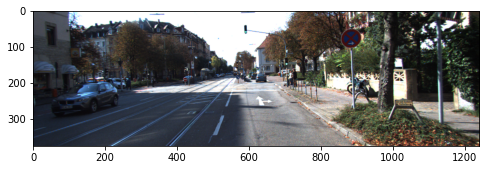

* Ground Truth


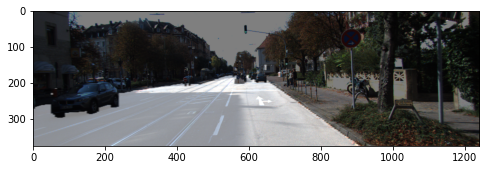

In [ ]:
get_origin(1)

In [ ]:
# IoU와 도로 영역 추측 결과를 합성한 이미지 출력을 한번에 쉽게 하기 위한 함수
def get_output_simple(model, i, threshold=0.5): # 매개변수로 모델과 이미지 넘버, threshold 값을 받는다.
  image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png'
  output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
  label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
  preproc = test_preproc

  org_img = imread(image_path)
  img_data = {"image":org_img}
  
  proc_data = preproc(**img_data)
  
  seg = model(np.expand_dims(proc_data["image"]/255, axis=0))
  seg = (seg[0].numpy()>threshold).astype(np.uint8).squeeze()*255
  pred = seg/255

  seg = Image.fromarray(seg).resize((org_img.shape[1], org_img.shape[0])).convert('RGBA')
  bg_img = Image.fromarray(org_img).convert('RGBA')

  output = Image.blend(bg_img, seg, alpha=0.5)


  if label_path:
    label_img = imread(label_path)
    label_data = {"image":label_img}
    proc_label = preproc(**label_data)
    proc_label = proc_label["image"]
    target = (proc_label == 7).astype(np.uint8)*1
    IoU = calculate_iou_score(target, pred) # IoU를 계산하고 출력
    plt.figure(figsize=(8, 8))
    plt.imshow(output) # 이미지 출력
    plt.show() # 여러개의 이미지를 텍스트와 함께 순서에 맞게 출력하기 위해 필요
    

    return output, pred, target
  else:
    return output, pred, _


    # TODO: image_path로 입력된 이미지를 입력받아 preprocess를 해서 model로 infernece한 결과를 시각화하고 
    # 이를 output_path에 저장하는 함수를 작성해주세요.

In [ ]:
# 여러 모델의 결과를 한번에 확인하기 위한 함수 정의
def print_and_show(img_num, models, th = 0.5):
  print('-'*19)
  print(f'----- Image {img_num} -----')
  print('-'*19)
 
  get_origin(img_num)
  print('-'*19)
  
  if type(models) == list:
    for i, mo in enumerate(models):
      print(f'(Model {i+1})')
      output, prediction, target = get_output_simple(mo, img_num, threshold = th)
      print('-'*80)
  else:
    output, prediction, target = get_output_simple(models, img_num, threshold = th)
    print('-'*80)

image 5

-------------------
----- Image 5 -----
-------------------
* Original


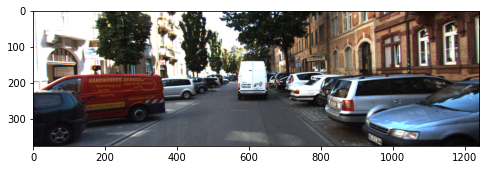

* Ground Truth


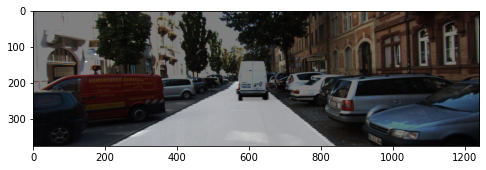

-------------------
(Model 1)
IoU : 0.454118


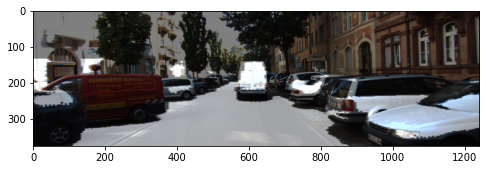

--------------------------------------------------------------------------------
(Model 2)
IoU : 0.391482


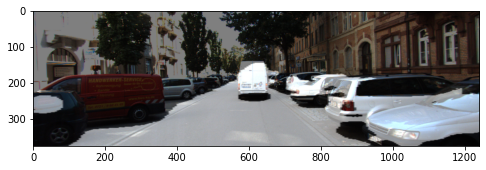

--------------------------------------------------------------------------------
(Model 3)
IoU : 0.558938


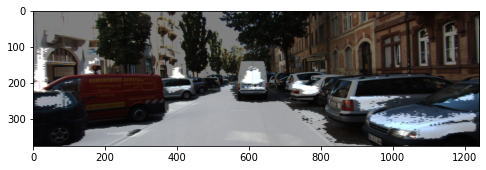

--------------------------------------------------------------------------------
(Model 4)
IoU : 0.646963


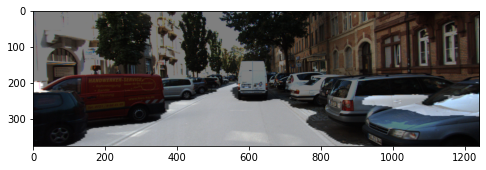

--------------------------------------------------------------------------------
(Model 5)
IoU : 0.000000


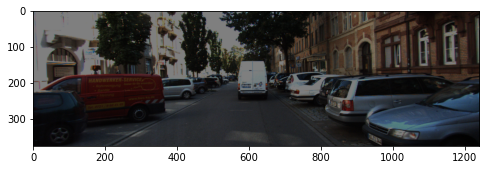

--------------------------------------------------------------------------------
(Model 6)
IoU : 0.566295


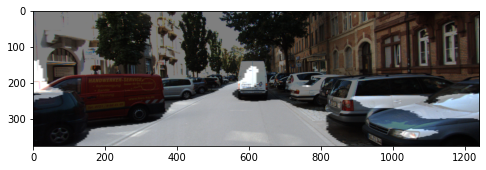

--------------------------------------------------------------------------------


In [ ]:
print_and_show(5, [model, model_unetpp, model_unetpp_bc, model_unetpp_dp, model_unetpp_dp_bc, model_unetpp_dp_dc])

image 15

-------------------
----- Image 15 -----
-------------------
* Original


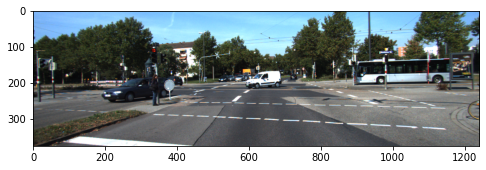

* Ground Truth


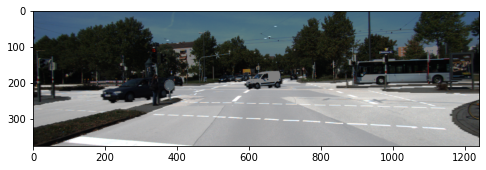

-------------------
(Model 1)
IoU : 0.851092


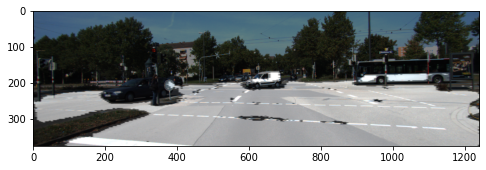

--------------------------------------------------------------------------------
(Model 2)
IoU : 0.813882


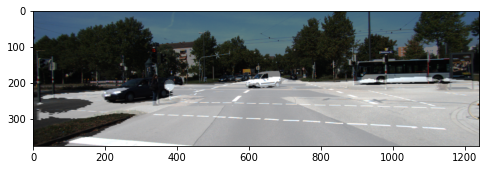

--------------------------------------------------------------------------------
(Model 3)
IoU : 0.604210


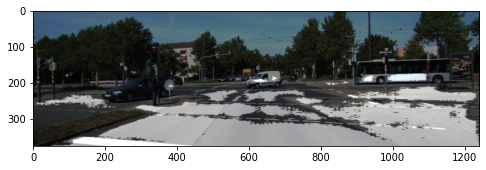

--------------------------------------------------------------------------------
(Model 4)
IoU : 0.728418


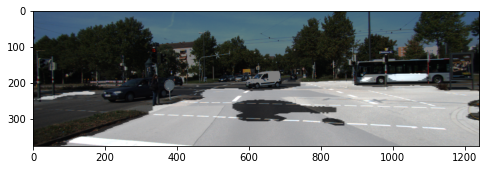

--------------------------------------------------------------------------------
(Model 5)
IoU : 0.000000


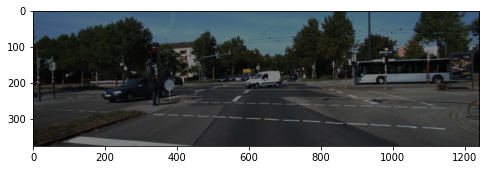

--------------------------------------------------------------------------------
(Model 6)
IoU : 0.793861


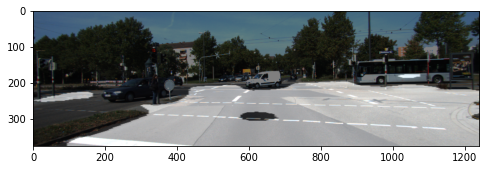

--------------------------------------------------------------------------------


In [ ]:
print_and_show(15, [model, model_unetpp, model_unetpp_bc, model_unetpp_dp, model_unetpp_dp_bc, model_unetpp_dp_dc])

image 25

-------------------
----- Image 25 -----
-------------------
* Original


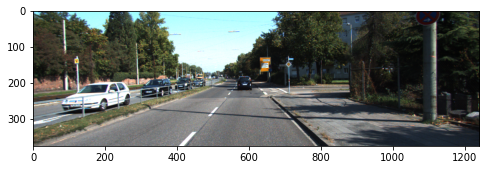

* Ground Truth


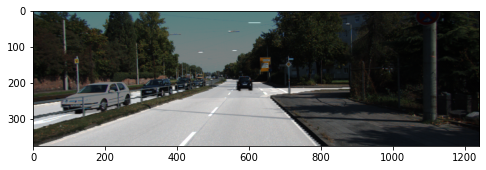

-------------------
(Model 1)
IoU : 0.573928


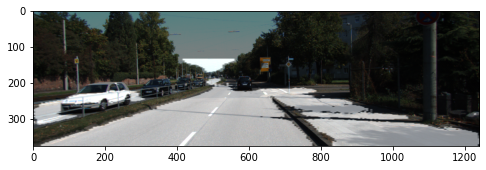

--------------------------------------------------------------------------------
(Model 2)
IoU : 0.481277


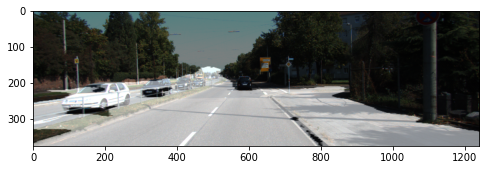

--------------------------------------------------------------------------------
(Model 3)
IoU : 0.613409


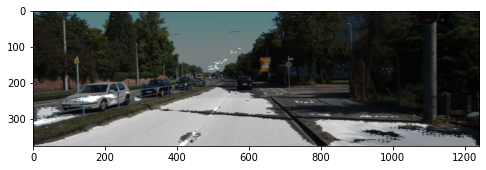

--------------------------------------------------------------------------------
(Model 4)
IoU : 0.603236


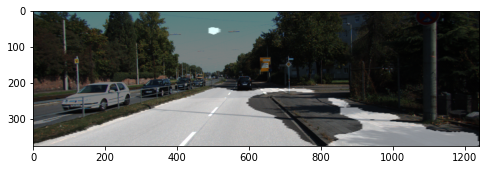

--------------------------------------------------------------------------------
(Model 5)
IoU : 0.000000


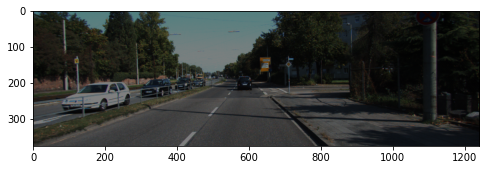

--------------------------------------------------------------------------------
(Model 6)
IoU : 0.580699


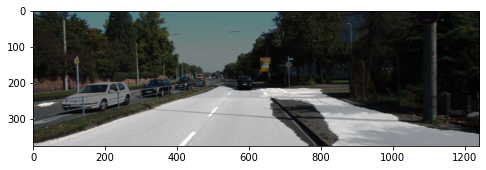

--------------------------------------------------------------------------------


In [ ]:
print_and_show(25, [model, model_unetpp, model_unetpp_bc, model_unetpp_dp, model_unetpp_dp_bc, model_unetpp_dp_dc])

# **Step 4. 회고**

  U-Net++ 모델이 너무 어려웠음. 경민님꺼를 많이 참고햇음 ㅠㅠ..........
논문도 어렵고,,,,,,^^.

